In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Vanilla Call Option


In [ ]:
# pricing a vanilla option
def option_payoff(S, K, option_type):
  payoff = 0.0
  if option_type == "call":
    payoff = max(S - K, 0)
  elif option_type == "put":
    payoff = max(K - S, 0)
  
  return payoff 

def option_moneyness(S, K, option_type):
  moneyness = 0.0
  if option_type == "call":
    moneyness = max(np.sign(S - K), 0)
  elif option_type == "put":
    moneyness = max(np.sign(K - S), 0)
  return moneyness 

In [ ]:
S0 = 100.0
K = 105.0
T = 0.5
r = 0.02
q = 0.04
sigma = 0.3


option_type = "call"
n_steps = 100          # number of time steps 
sp.random.seed(31521)  # make result reproducible 
n_simulation = 100000   # number of simulation 

dt = T/n_steps
sqrt_dt = np.sqrt(dt) 
payoff = np.zeros((n_simulation), dtype = float) 
S_end = np.zeros((n_simulation), dtype = float)
vega_end = np.zeros((n_simulation), dtype = float)  
y = np.zeros((n_simulation), dtype = float) 
step = range(0, int(n_steps), 1)

for i in range(0, n_simulation): # inspired from class code
  ST = S0
  W = 0.0
  for j in step:
    epsilon = sp.random.normal()
    ST *= np.exp((r - q - 0.5*sigma*sigma)*dt + sigma*epsilon*sqrt_dt)
    W += sqrt_dt*epsilon
  payoff[i] = option_payoff(ST, K, option_type)
  S_end[i] = option_moneyness(ST, K, option_type)*ST
  vega_end[i] = np.exp(-r*T) * option_moneyness(ST, K, option_type) * (ST/sigma) * (np.log(ST/S0) - (r - q + (sigma**2 / 2))*T)
  y[i] = W 

option_price = np.mean(payoff)*np.exp(-r*T)
err_price = np.std(payoff)*np.exp(-r*T)/np.sqrt(n_simulation)
#get call delta using pathwise derivative 

option_delta = np.mean(S_end)*np.exp(-r*T)/S0 ## pathwise
option_delta2 = np.mean(np.exp(-r*T) * payoff * (y/(sigma*(T)*S0))) # score function 


err_delta = np.std(S_end)*np.exp(-r*T)/S0/np.sqrt(n_simulation) ## pathwise 
err_delta2 = np.std(payoff * (y/(sigma*(T)*S0)))*np.exp(-r*T)/np.sqrt(n_simulation) ## score function

#get vega using score function 
option_vega = np.mean(payoff*((y*y/T - 1)/sigma - y))*np.exp(-r*T) 
option_vega2 = np.mean(vega_end) ## pathwise
err_vega = np.std(payoff*((y*y/T - 1)/sigma - y))*np.exp(-r*T)/np.sqrt(n_simulation)
err_vega2 = np.std(vega_end)/np.sqrt(n_simulation)

print(option_type + ' Price =', round(option_price, 6))
print(option_type + ' Error Price =', round(err_price, 4))
print(option_type + ' Delta (score function) =', round(option_delta2, 6))
print(option_type + ' Delta (pathwise derivative) =', round(option_delta, 6))
print(option_type + ' Error Delta (score function) =', round(err_delta2, 4))
print(option_type + ' Error Delta (pathwise derivative)  =', round(err_delta, 4))
print(option_type + ' Vega (score function) =', round(option_vega, 6)) 
print(option_type + ' Vega (pathwise derivative) =', round(option_vega2, 6)) 
print(option_type + ' Error Vega (score function) =', round(err_vega, 4))
print(option_type + ' Error Vega (pathwise derivative) =', round(err_vega2, 4))

call Price = 5.87479
call Error Price = 0.0374
call Delta (score function) = 0.422446
call Delta (pathwise derivative) = 0.422893
call Error Delta (score function) = 0.0037
call Error Delta (pathwise derivative)  = 0.0018
call Vega (score function) = 27.108541
call Vega (pathwise derivative) = 27.194123
call Error Vega (score function) = 0.5059
call Error Vega (pathwise derivative) = 0.1651


# Asian Option

In [ ]:
#Pricing average strike option using MC
#convention: averaging starts moment after avg_start_time

S0 = 100.0
K = 105.0
T = 0.5
avg_start_time = 0
r = 0.02
q = 0.04
sigma = 0.3
option_type = "call"
n_steps = int(200 * T) # number of time steps 
sp.random.seed(31521)  # make result reproducible 
n_simulation = 100000   # number of simulation

dt = T/n_steps
sqrt_dt = np.sqrt(dt)
n_avg = (T - avg_start_time)/dt
if abs(avg_start_time/dt - round(avg_start_time/dt)) > 0.00001:
  warnings.warn('dt incompatible with avg_start_time')

payoff = np.zeros((n_simulation), dtype = float)
J_end = np.zeros((n_simulation), dtype = float) 
dj_dsigma = np.zeros((n_simulation), dtype = float) 
step = range(0, int(n_steps), 1)
for i in range(0, n_simulation):# inspired from class code
  ST = S0
  sum_S = 0.0
  t_path = 0.0
  ds_dsigma = 0.0
  for j in step:
    epsilon = sp.random.normal()
    t_path += dt
    ST *= np.exp((r - q - 0.5*sigma**2)*dt + sigma*epsilon*sqrt_dt)
    if t_path > avg_start_time + 0.00001:
      sum_S += ST
      ds_dsigma += (ST/sigma)*(np.log(ST/S0) - (r - q + ((sigma**2)/2))*t_path)


    
  avg_S = sum_S/n_avg
  dj_dsigma[i] = (1/n_avg) * option_moneyness(avg_S, K, option_type) * ds_dsigma  ## added
  payoff[i] = option_payoff(avg_S, K, option_type) # added
    
  J_end[i] = option_moneyness(avg_S, K, option_type)*avg_S # Added of end value

option_price = np.mean(payoff)*np.exp(-r*T)
err_price = np.std(payoff)*np.exp(-r*T)/np.sqrt(n_simulation)


option_delta = np.mean(J_end)*np.exp(-r*T)/S0 
err_delta = np.std(J_end)*np.exp(-r*T)/S0/np.sqrt(n_simulation)

option_vega = np.mean(np.exp(-r*T)*dj_dsigma)
err_vega = np.std(dj_dsigma)*np.exp(-r*T)/np.sqrt(n_simulation)

print(option_type + ' price =', round(option_price, 6))
print(option_type + ' err_price =', round(err_price, 4))

print(option_type + ' delta =', round(option_delta, 6))
print(option_type + ' err_delta =', round(err_delta, 4))

print(option_type + ' vega =', round(option_vega, 6)) 
print(option_type + ' err_vega =', round(err_vega, 4))

call price = 2.729126
call err_price = 0.0187
call delta = 0.345446
call err_delta = 0.0017
call vega = 15.093795
call err_vega = 0.0901


In [ ]:
def asian_option_mc(S0, K, T, avg_start_time, r, q, sigma, option_type, seed, sim_size):
  n_steps = 100 # number of time steps 
  sp.random.seed(seed)  # make result reproducible 
  n_simulation = sim_size   # number of simulation

  dt = T/n_steps
  sqrt_dt = np.sqrt(dt)
  n_avg = (T - avg_start_time)/dt
  if abs(avg_start_time/dt - round(avg_start_time/dt)) > 0.00001:
    warnings.warn('dt incompatible with avg_start_time')

  payoff = np.zeros((n_simulation), dtype = float)
  J_end = np.zeros((n_simulation), dtype = float) 
  dj_dsigma = np.zeros((n_simulation), dtype = float) 
  step = range(0, int(n_steps), 1)
  for i in range(0, n_simulation):
    ST = S0
    sum_S = 0.0
    t_path = 0.0
    ds_dsigma = 0.0
    for j in step:
      epsilon = sp.random.normal()
      t_path += dt
      ST *= np.exp((r - q - 0.5*sigma**2)*dt + sigma*epsilon*sqrt_dt)
      if t_path > avg_start_time + 0.00001:
        sum_S += ST
        ds_dsigma += (ST/sigma)*(np.log(ST/S0) - (r - q + ((sigma**2)/2))*t_path)


      
    avg_S = sum_S/n_avg
    dj_dsigma[i] = (1/n_avg) * option_moneyness(avg_S, K, option_type) * ds_dsigma 
    payoff[i] = option_payoff(avg_S, K, option_type)
      
    J_end[i] = option_moneyness(avg_S, K, option_type)*avg_S 

  option_price = np.mean(payoff)*np.exp(-r*T)
  err_price = np.std(payoff)*np.exp(-r*T)/np.sqrt(n_simulation)

  
  option_delta = np.mean(J_end)*np.exp(-r*T)/S0 
  err_delta = np.std(J_end)*np.exp(-r*T)/S0/np.sqrt(n_simulation)

  option_vega = np.mean(np.exp(-r*T)*dj_dsigma)
  err_vega = np.std(dj_dsigma)*np.exp(-r*T)/np.sqrt(n_simulation)

  return option_price, err_price, option_delta, err_delta, option_vega, err_vega


In [ ]:
S0 = 100.0
K = 105.0
T = 0.5
# avg_start_time = 0.495
r = 0.02
q = 0.04
sigma = 0.3
option_type = "call"

avg_points = np.array([0.25, 0.325, 0.45, 0.475, 0.495])
price = np.zeros(avg_points.shape)
price_err = np.zeros(avg_points.shape)
delta = np.zeros(avg_points.shape)
delta_err = np.zeros(avg_points.shape)
vega = np.zeros(avg_points.shape)
vega_err = np.zeros(avg_points.shape)

counter = 0
for avg_start_time in avg_points:
  option_data = asian_option_mc(S0,K,T, avg_start_time, r, q, sigma, option_type, 31521, 100000)

  price[counter] = option_data[0]
  price_err[counter] = option_data[1]
  delta[counter] = option_data[2]
  delta_err[counter] = option_data[3]
  vega[counter] = option_data[4]
  vega_err[counter] = option_data[5]
  
  counter += 1





In [ ]:
values = pd.DataFrame({'Average Start Time (years)': avg_points, 'Price ($)':price, 'Delta':delta, 'Vega': vega})
values

,Average Start Time (years),Price ($),Delta,Vega
0,0.250,4.507363,0.398262,22.026837
1,0.325,4.952627,0.407101,23.715154
2,0.450,5.632168,0.419375,26.283042
3,0.475,5.759733,0.420515,26.754210
4,0.495,5.874790,0.422893,27.194123


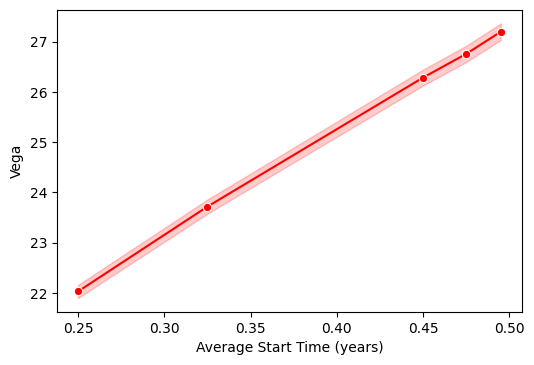

In [ ]:
fig = plt.figure(dpi=100)
ax = sns.lineplot(data=values,x='Average Start Time (years)', y='Vega', color='r', marker='o') 
plt.fill_between(avg_points, vega -vega_err, vega + vega_err, color='r', alpha=0.2)

plt.show()
